# 3. ConvLSTM

![convlstm](https://miro.medium.com/max/942/1*u8neecA4w6b_F1NgnyPP0Q.png)

For the last sample submission, we are going to cover **ConvLSTM** that are frequently used for future video frame prediction. In addition to that, we are going to mix up things a bit. 
First of all, we are going to use TensorFlow rather than PyTorch, just to demonstrate how the former can be used to make a valid submission. Consequently, we are not going to use a separate ```model.py``` script and instead, the model is going to be trained within the following notebook and saved for the further use. Lastly, we are going to use MSE loss (used in some papers).

## Theory

![LSTM cell](https://miro.medium.com/max/1400/1*ujzOtlfaJFWhKb6HS9RS-g.png)

As the name of the model migth suggest, **ConvLSTM** system combines Convolutional layers with the Long Short Term Memory architecture. Applying such combination to our problem seems to be quite logical: we are dealing with visual data in which the order of elements matters.

In short, ConvLSTM approach is as follows:

- **Convolutional layers**. Image is first passed through some Convolutional layers to filter important features.
- These features are then connected with fully-connected **Dense network**.
- The 3D input is then passed though LSTM architecture.

Fortunately to us, Keras already has a predefined ConvLSTM layer that can be used to implement such system. The parameters set inside the ```ConvLSTM``` function remain similar to those in the regular ```Conv``` layer, the main difference appears in the input (as well as output) dimensions - it will become more clear as be go through.


## Implementation

Before implementing ConvLSTM system, we first have to decide on the exact approach we are going to take for the this problem. As we know, we have twelve 128x128 images as our input and we have to produce twenty-four 64x64 future images.

So far, we built models that took all twelve images as an input and produced twenty-four reduced images which increased the number of parameters in our model significantly. The following implementation will take a bit different approach:

- The input images will be **resized to 64x64** prior to passing them through the model
- Model will be trained to predict a **consecutive frame** rather than 24 new frames

#### Importing modules

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from numpy import float32
from dataset import ClimateHackDataset

plt.rcParams["figure.figsize"] = (20, 12)

#### Loading data

As the following implementation will use TensorFlow instead of PyTorch, we are going to import different ```dataset.py``` script than in the previous cases. In addition, we are no longer loading 12 and 24 images for the input-output data - as we are predicting the consecutive term, we are importing one image for each input-output pair. Other than that, the process of loading data remains the same.

In [2]:
BATCH_SIZE = 8
EPOCHS = 10

ch_dataset = ClimateHackDataset("data.npz", crops_per_slice=2)
coordinates, features, labels = ch_dataset.load_data()

#Expanding dimensions of our features and labels
features = np.expand_dims(features, -1)
labels = np.expand_dims(labels, -1)

Processing...


#### Preprocessing

Prior to building the ConvLSTM system, we need to preprocess our image data. The input image (128x128) has to be resized to (64x64) followed by normalization.

In addition, we need to make sure that our input data has the right number of dimensions. Similar to the regular Convolutional layers, we will need the final three dimensions that will corespond to height, width and the number of channels. In addition to that, we have already expanded the initial 3-dimensional imagery data to 4 dimensions (image sample). As the sequence of data matters, we need to add the additional 5th dimension, therefore, the previously described normalization will be followed by dimension expansion.

Overall, our input to ConvLSTM layer will have the shape of ```(batch_size, frame_num, width, height, channels)```

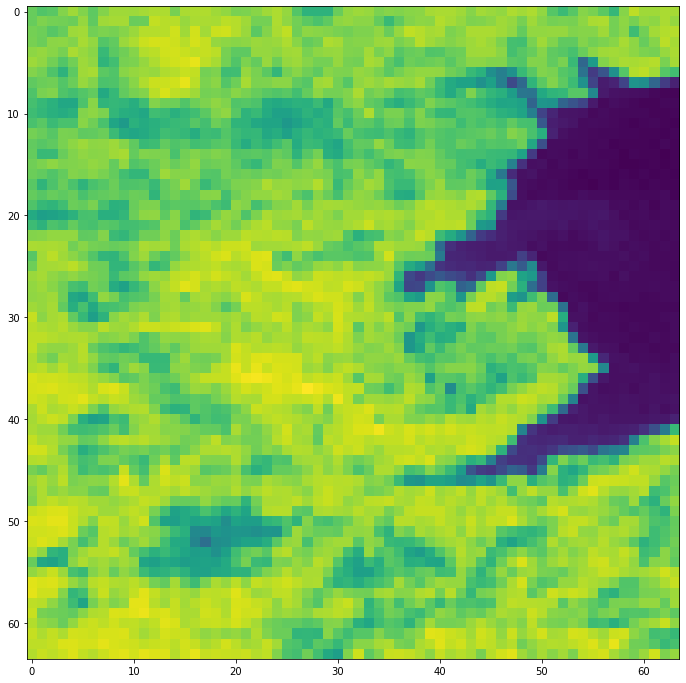

In [10]:
plt.imshow(X[0][0])

In [3]:
Images = features[:, 0, :, :, :]
# Resizing images to 64x64
X = tf.image.resize(Images, (64, 64))
# Expanding dimensions
X = np.expand_dims(X, axis = 1)

#### Building model

We will use ConvLSTM system presented in [this paper](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf). In short, it will contain:

- 3 **ConvLSTM2D** layers
- 2 **batch normalization** layers in between
- Last **Conv3D** layer for spatiotemporal resolution

In [4]:
inp = layers.Input(shape=(None, *X.shape[2:]))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x) * 1023

model = keras.models.Model(inp, x)

model.compile(loss=tf.keras.losses.mse, optimizer='adam')

Before training our model, it is also crucial to check that the number of dimensions throughout all layers are correct and we are getting the output we expected.

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 64)  256      
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                             

#### Training model

In [ ]:
model.fit(X, labels, batch_size = 8, epochs = 10)

In [ ]:
# After the training, make sure to save your model
model.save('saved_model/my_model')

#### Testing

Before preparing the ```evaluation.py``` script and submitting our model, let's look at sample prediction.

In [6]:
# Loading sample image
img = features[-10]

# Resizing and normalizing image
img = np.expand_dims(tf.image.resize(img, (64, 64)), axis = 0) / 1023

In [7]:
# Loading model
model = tf.keras.models.load_model('submission/saved_model/my_model')

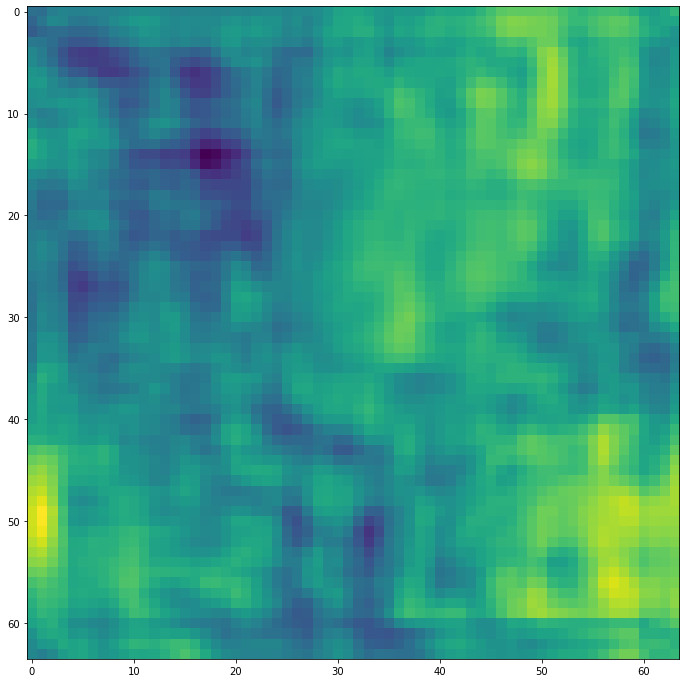

In [9]:
#Generating prediction
pred = model.predict(img)

# Reducing dimensions to visualize image
pred = np.squeeze(np.squeeze(pred, axis = 0), axis = 0)

plt.imshow(pred)

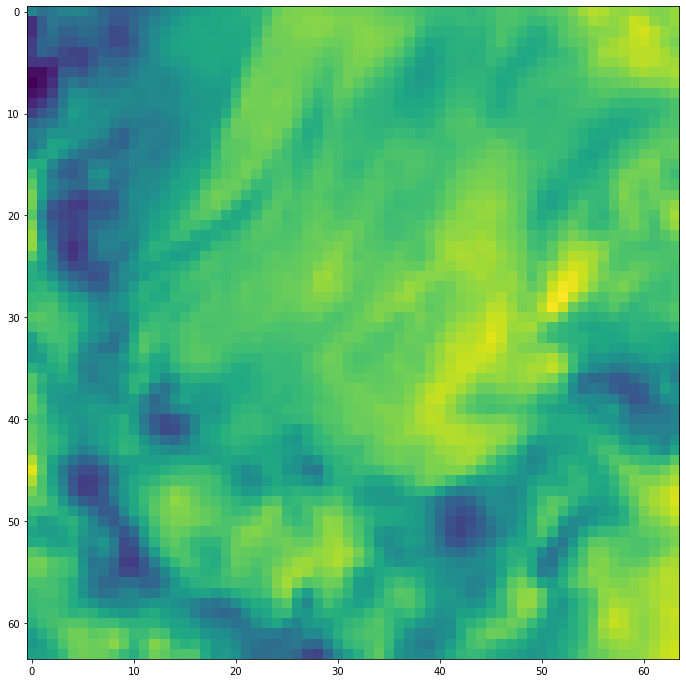

In [10]:
plt.imshow(labels[-10][0])

#### Deploying model

The only custom script that needs to be changed for such system is the ```evaluation.py```. Within the script, you will need to:
- Load the model
- Preprocess the last image from the given twelve images
- Pass image through the model
- Use generated image as a new input for the model
- Repeat the last two steps until you have 24 images

***Depending on the time you are reading this source, such scripts may already be available to use***